In [17]:
using Fretem, Potential, Alphabeta, PyPlot, Printf

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1260


### Part 1: Get collocation points and integration kernel for whole domain

In [4]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 10 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{eq}(x)$ and $D$

In [5]:
k_ref = 1 # unit: kcal/mol/angstrom^2
Vref = harmonic_well_k_mean(xref, k_ref, xavg)
rho_eq = get_rhoeq(Vref, w0)
peq = rho_eq .* rho_eq
D = 7.75e10; # Diffusion coefficient, unit: angstrom^2 s-1

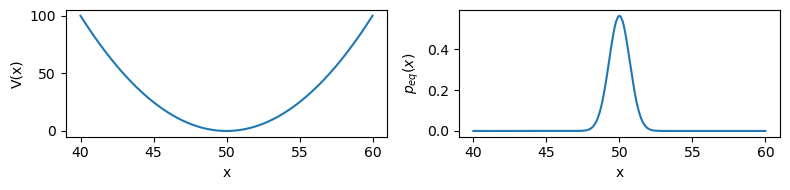

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,2))

ax = axes[1]
ax.plot(xref, Vref)
ax.set_xlabel("x")
ax.set_ylabel("V(x)")

ax = axes[2]
ax.plot(xref, peq)
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x)\$")

plt.tight_layout()
plt.show()

### Part 3: Get eigenvalues and eigenvectors

In [42]:
Nv = 36 # Number of eigenvectors
LQ, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

### Part 4: Set very sharp $V(x)$ and $p(x)$

In [49]:
k_delta = 10 # unit: kcal/mol/angstrom^2
V_delta = harmonic_well_k_mean(xref, k_delta, xavg)
rho_delta = get_rhoeq(V_delta, w0)
p_delta = rho_delta .* rho_delta;

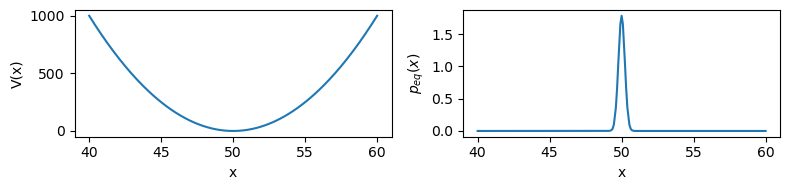

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,2))

ax = axes[1]
ax.plot(xref, V_delta)
ax.set_xlabel("x")
ax.set_ylabel("V(x)")

ax = axes[2]
ax.plot(xref, p_delta)
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x)\$")

plt.tight_layout()
plt.show()

In [51]:
# Check probability conservation
sum(w0 .* p_delta)

1.0000000000000016

### Part 5: Get $\left<\alpha_{t_0} | x \right> = \frac{p(x,0)}{\sqrt{p_{eq}(x)}} = \frac{C_0}{ \sqrt{C_{eq}}} \exp{(-V_0(x) + \frac{V_{eq}(x)}{2})}$

In [52]:
alpha_t0 = get_alpha_t0_x_by_V0_Veq(w0, V_delta, Vref);

### Part 6: Get $c_i = \left<\alpha_{t0} | \psi_i \right>$, where $i=1,\cdots,N_v$ and get $p_{appr}$

In [53]:
c_array = Fretem.get_coefficients_by_proj(w0, alpha_t0, Qx, Nv);
p0_appr = Fretem.rebuild_p0_by_Qx_carray(Nv, c_array, Qx, rho_eq)
R = Fretem.get_residual(p_delta, p0_appr)

0.4775552542336967

### Part 7: Plot

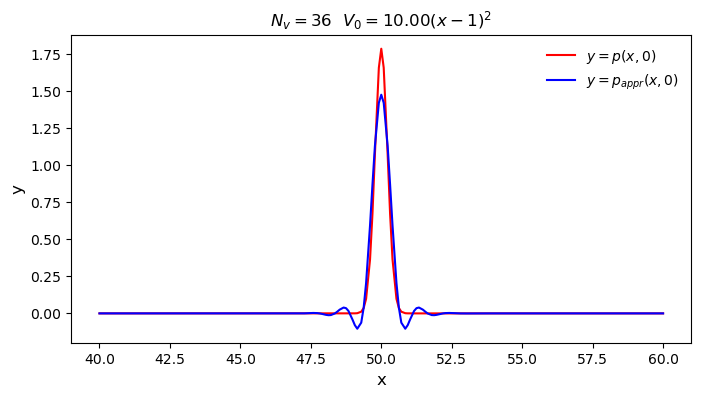

In [54]:
figsize = (8,4)
lbfz = 12
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
ax.plot(xref, p_delta, label="\$ y = p(x,0)\$", color="red")
ax.plot(xref, p0_appr, label="\$ y = p_{appr}(x,0)\$", color="blue")
ax.legend(frameon=false)
ax.set_xlabel("x", fontsize=lbfz)
ax.set_ylabel("y", fontsize=lbfz)
title = @sprintf "\$ N_v=%d~~V_0=%.2f(x-1)^2  \$" Nv k_delta
ax.set_title(title)
#plt.savefig("k10.png", dpi=150)
plt.show()